In [384]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string

In [385]:
import nltk
from nltk.corpus import stopwords

import language_tool_python
from textblob import TextBlob

In [386]:
#some imports for ML

import keras

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [387]:
def display_training_curves(history): #this function will be useful for model evaulation
    fig, ax = plt.subplots(ncols=1, nrows=2,figsize=(7,10))
    ax[0].plot(history.history['val_acc'], label='validation accuracy')
    ax[0].scatter(y=history.history['acc'],x=range(0,len(history.history['acc'])), label='training accuracy')
    ax[0].legend()
    ax[0].title.set_text('Training and Validation Accuracy')
    #ax[0].set_xlabel('number of epochs')
    #ax[0].set_ylim(0,max(history.history['binary_accuracy']))
    
    ax[1].plot(history.history['val_loss'], label='validation loss')
    ax[1].scatter(y=history.history['loss'],x=range(0,len(history.history['loss'])), label='training loss')
    ax[1].title.set_text('Training and Validation loss')
    ax[1].legend()
    ax[1].set_xlabel('number of epochs')
    #ax[1].set_ylim(0)

In [388]:
#check paths of the datasets
import os
for dirname, _, filenames in os.walk('/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/validation.csv
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/.DS_Store
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/test.csv
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/train.csv
/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/english_test_with_labels.csv


In [389]:
#load all data
df_train = pd.read_csv("/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/train.csv", index_col='id')
df_val = pd.read_csv("/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/validation.csv", index_col='id')
df_test = pd.read_csv("/Users/kuba/Desktop/MACHINE LEARNING/COVID FAKE NEWS/constraint_data/english_test_with_labels.csv", index_col='id')



In [390]:
#create a cumulative dataset
df = (df_train.append(df_val)).append(df_test)

In [391]:
df.reset_index(inplace=True, drop=True)
df

tweet label
0      The CDC currently reports 99031 deaths. In gen...  real
1      States reported 1121 deaths a small rise from ...  real
2      Politically Correct Woman (Almost) Uses Pandem...  fake
3      #IndiaFightsCorona: We have 1524 #COVID testin...  real
4      Populous states can generate large case counts...  real
...                                                  ...   ...
10695  #CoronaVirusUpdates: State-wise details of Tot...  real
10696  Tonight 12(midnight) onwards Disaster Manageme...  fake
10697  296 new cases of #COVID19Nigeria; Plateau-85 E...  real
10698  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...  real
10699  More than half of pregnant women recently admi...  real

[10700 rows x 2 columns]

In [392]:
df_train.head()

tweet label
id                                                         
1   The CDC currently reports 99031 deaths. In gen...  real
2   States reported 1121 deaths a small rise from ...  real
3   Politically Correct Woman (Almost) Uses Pandem...  fake
4   #IndiaFightsCorona: We have 1524 #COVID testin...  real
5   Populous states can generate large case counts...  real

In [393]:
#check for NULL Values

print("null values:\n", df.isnull().any())

null values:
 tweet    False
label    False
dtype: bool


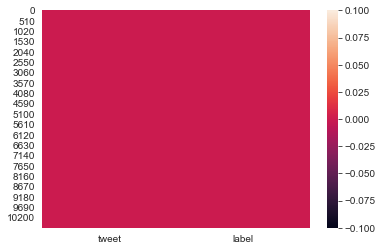

In [394]:
sns.heatmap(df.isnull())

<br><strong>Let's investigate the length of the tweets

In [395]:
def char_count(text):
    count = len(text)
    return count

In [396]:
df['char_count'] = df['tweet'].apply(char_count)

In [397]:
def word_count(text):
    to_words = text.split(" ")
    count = len(to_words)
    return count

In [398]:
df['word_count'] = df['tweet'].apply(word_count)

In [399]:
df.sort_values(by="char_count", ascending = False).head()

tweet label  char_count  \
10029  I’ve never had a chance to work on something t...  real       10170   
270    Amoxi" Capsule made in US is the only medicine...  fake        8846   
1109   Actors" applauded Macron when he visited the s...  fake        5040   
9066   NYC man drops dead in middle of street — suspe...  fake        2160   
8153   I'm so happy that we’re able to do something v...  real        2135   

       word_count  
10029        1433  
270          1409  
1109          823  
9066          330  
8153          297

In [400]:
df.sort_values(by="char_count", ascending = False).tail()

tweet label  char_count  word_count
2407  Cocaine cures COVID-19.  fake          23           3
3141   COVID-19 TEST a FRAUD?  fake          22           4
1883    COVID-19 is Airborne.  fake          21           3
268      There is no pandemic  fake          20           4
1140       Pier Luigi Bersani  fake          18           3

In [401]:
print(f"""Found {len(df.loc[df.char_count > 280, :])} records with character count higher than 280, which indicates that these are not legitimate tweets""")

Found 1375 records with character count higher than 280, which indicates that these are not legitimate tweets


It seems that our dataset is not perfect because we have over 1k of tweets which are not tweets really, since the tweet character limit is 280. Let's further investigate them.

In [402]:
df.loc[df.char_count > 280, :].groupby('label').count().tweet #first, let's check the distibution over labels

label
fake     356
real    1019
Name: tweet, dtype: int64

In [403]:
df.loc[df.char_count > 280, :].char_count.mean() #what is the mean length of these tweets?

324.328

In [404]:
df.loc[df.char_count > 280, :].groupby('label').mean()

char_count  word_count
label                        
fake   376.002809   57.053371
real   306.274779   43.569185

Now, let's investigate it for proper-length records 

In [405]:
print(f"""Found {len(df.loc[df.char_count <= 280, :])} records with character count lower than (or equal to) 280, which indicates that these may be legitimate tweets
Distribution of labels among these tweets is:
FAKE - {df.loc[df.char_count <= 280, :].groupby('label').count().tweet[0]}
REAL - {df.loc[df.char_count <= 280, :].groupby('label').count().tweet[1]}

Character count mean is: {round(df.loc[df.char_count <= 280, :].char_count.mean(),2)}
Character count median is: {df.loc[df.char_count <= 280, :].char_count.median()}

Word count mean is {round(df.loc[df.word_count <= 280, :].word_count.mean(),2)}
Word count median is {round(df.loc[df.word_count <= 280, :].word_count.median(),2)}""")

Found 9325 records with character count lower than (or equal to) 280, which indicates that these may be legitimate tweets
Distribution of labels among these tweets is:
FAKE - 4744
REAL - 4581

Character count mean is: 160.89
Character count median is: 146.0

Word count mean is 26.57
Word count median is 25.0


In [406]:
pd.DataFrame(df.loc[df.char_count <= 280, :].groupby('label').count().tweet) #labels distribution

tweet
label       
fake    4744
real    4581

In [407]:
df.loc[df.char_count <= 280, :].groupby('label').mean() #mean and median separately for both labels

char_count  word_count
label                        
fake   125.741358    18.85371
real   197.293386    29.37721

In [408]:
df['proper'] = df.char_count.apply(lambda x: True if x <= 280 else False)
pd.DataFrame(df.groupby(['proper','label']).count()['tweet'])

tweet
proper label       
False  fake     356
       real    1019
True   fake    4744
       real    4581

Text(0, 0.5, 'Tweets count')

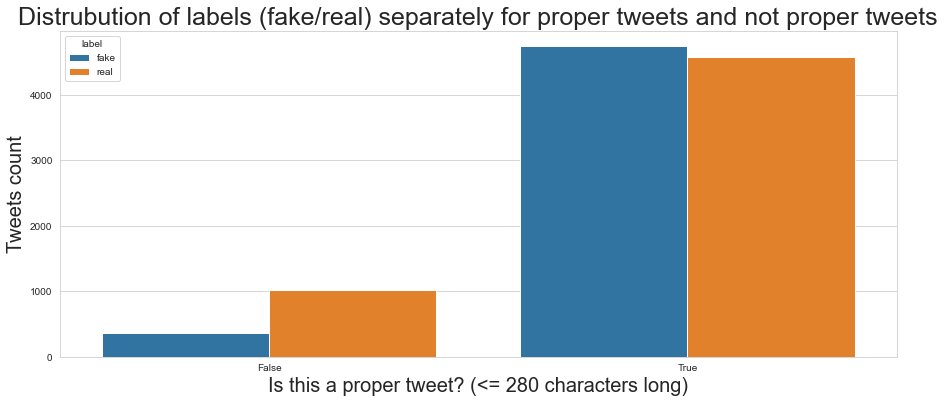

In [409]:
plt.figure(figsize=(15,6))

sns.barplot(data=pd.DataFrame(df.groupby(['proper','label']).count()['tweet']).reset_index(), x='proper', y='tweet', hue='label')

plt.title("Distrubution of labels (fake/real) separately for proper tweets and not proper tweets",fontdict={"fontsize":25})

plt.xlabel("Is this a proper tweet? (<= 280 characters long)", fontdict={"fontsize":20})

plt.ylabel("Tweets count", fontdict={"fontsize":20})

In [410]:
#let's not delete the Proper column for now as it may be useful in further analysis

#del df['proper']

We can draw a conclusion that there are two groups of records:
- proper tweets (maximum 280 characters)
- false tweets (longer than 280 characters)

<br>
For the first group, labels (fake/real) seem to be distributed equally.<br>
The second group (records longer then maximum tweet length) is not equally distributed over our labels. There is around 1k of such records that are labeled as REAL and only 350 labeled as FAKE.<br>
<br>
It may have a significant impact on the effectiveness of model training. One option of solving it is removing all of the False-tweet records (longer than 280 characters). However, in our case their count is signitifant (~10% of the whole dataset) - in such a case, we will keep them and truncate them before training.

<strong>Create copy the tweet column for further text processing</strong>

In [411]:
df['processed_tweet'] = df['tweet']

In [412]:
df.iloc[:3,:].head()

tweet label  char_count  \
0  The CDC currently reports 99031 deaths. In gen...  real         190   
1  States reported 1121 deaths a small rise from ...  real         129   
2  Politically Correct Woman (Almost) Uses Pandem...  fake         131   

   word_count  proper                                    processed_tweet  
0          29    True  The CDC currently reports 99031 deaths. In gen...  
1          18    True  States reported 1121 deaths a small rise from ...  
2          16    True  Politically Correct Woman (Almost) Uses Pandem...

<strong>URLs are not useful at all in our case - let's remove them

In [413]:
#removing URLs from tweets as they will not be usefull at all and will break wordclous
import re
def del_url(text):
    x = re.sub(r'http\S+', "",text)
    return x

In [ ]:
df['processed_tweet'] = df['processed_tweet'].apply(del_url)

<strong>Let's create a cumulative WordCloud for all of the tweets </strong>

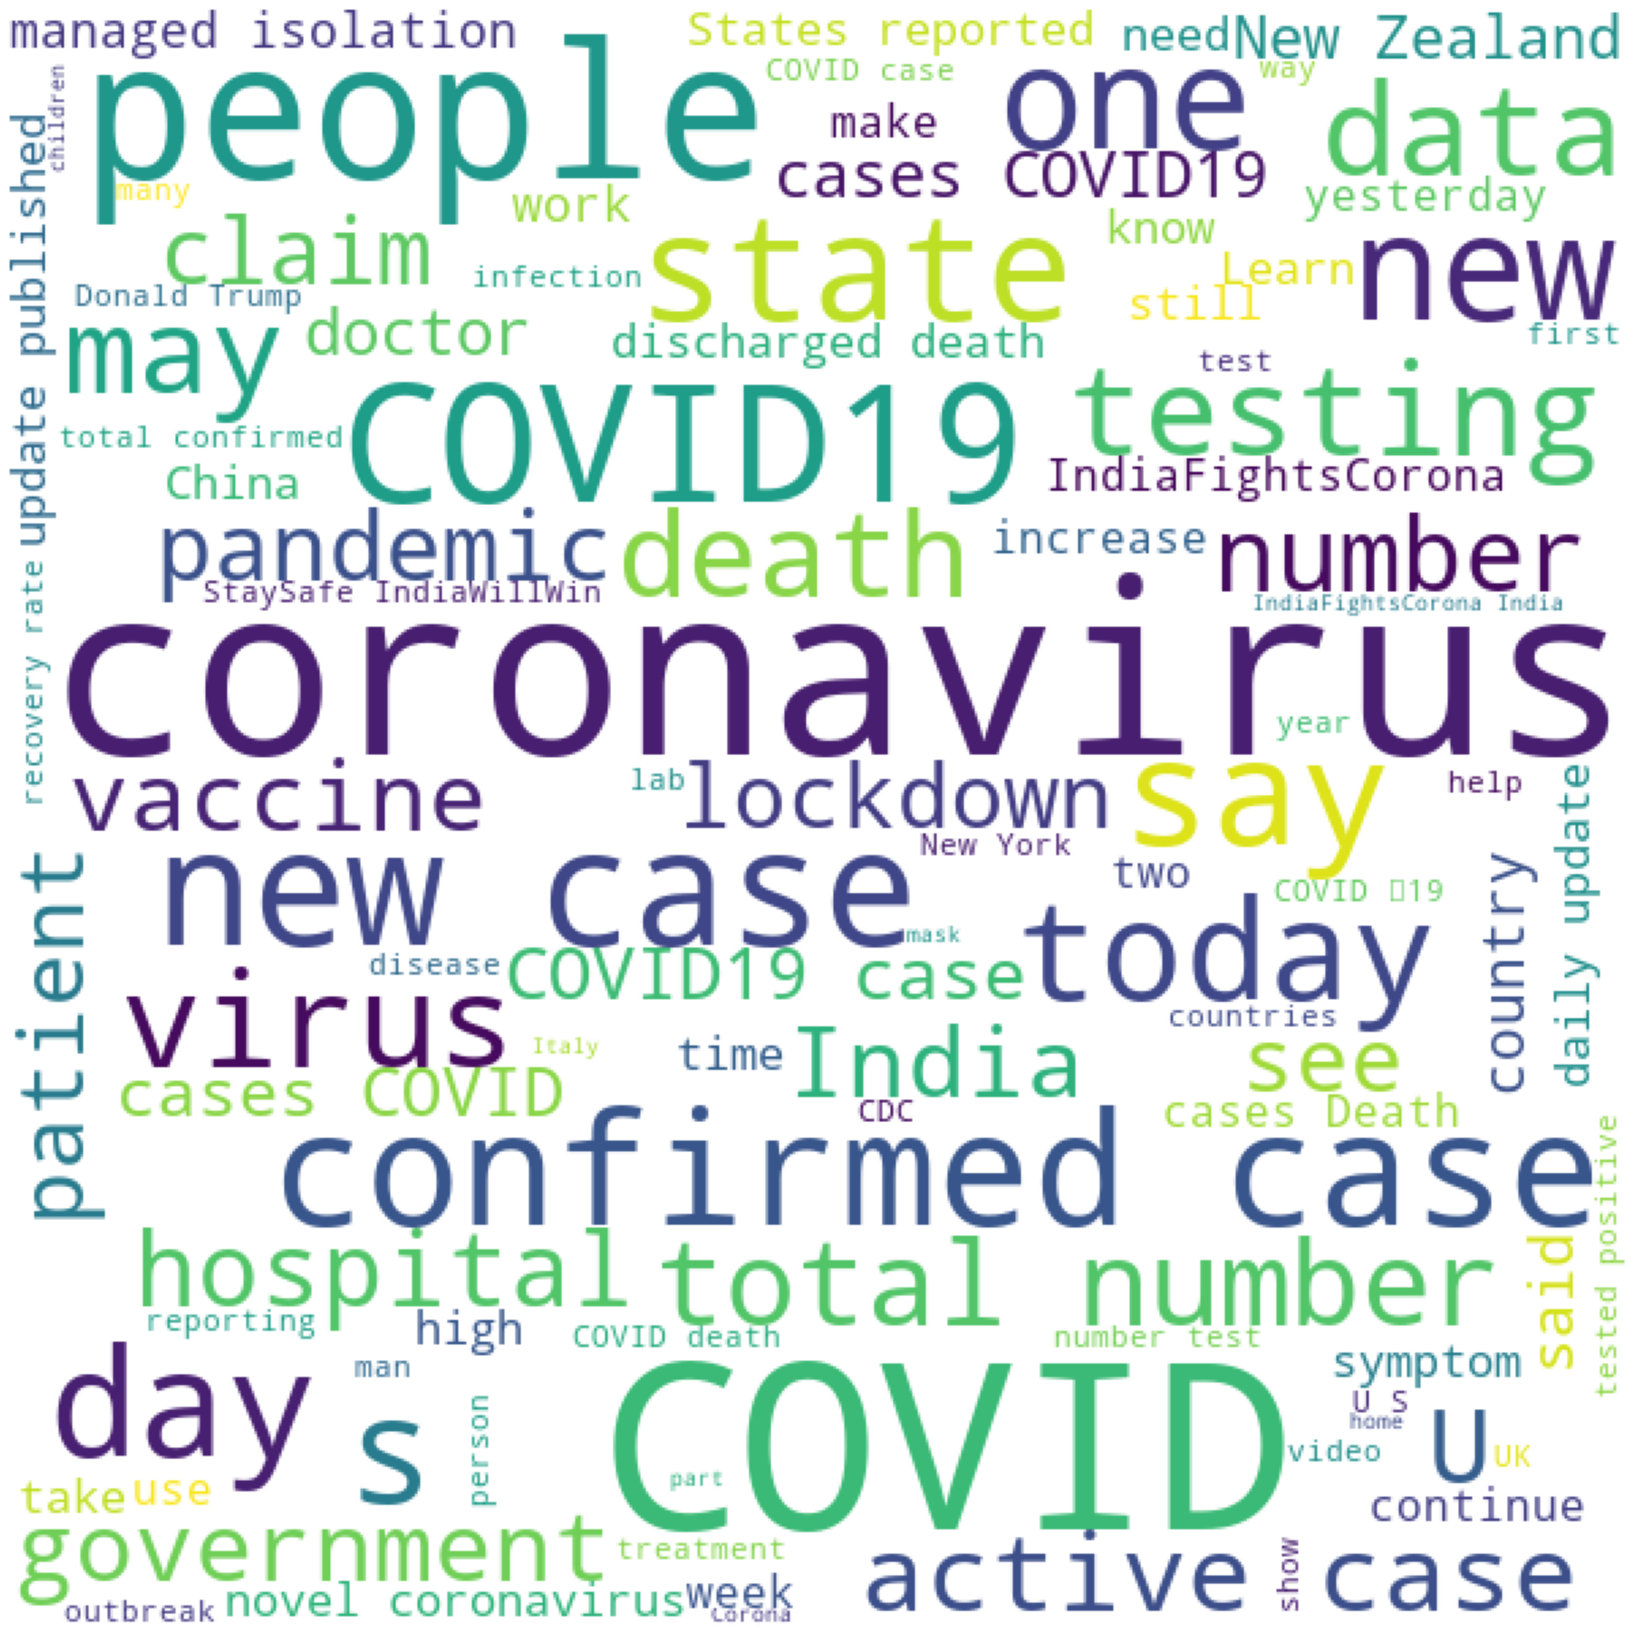

In [414]:
from wordcloud import WordCloud
from twokenize import tokenizeRawTweetText as twokenize

stop_words = list(stopwords.words("english"))

one_text = ("")

for item in list(df.processed_tweet):
    one_text += (item)
    one_text += ("\n")

words_tokens = twokenize(one_text)

filtered_text = [w for w in words_tokens if not w in stop_words]
wl_space_split = " ".join(filtered_text)
word_cloud_1 = WordCloud(max_words=100, width=600, height=600, background_color='white').generate(wl_space_split)


plt.figure(figsize=(30,30))
plt.imshow(word_cloud_1)
plt.axis("off")
plt.show()

<strong>WordClouds for fake and real news separately</strong>

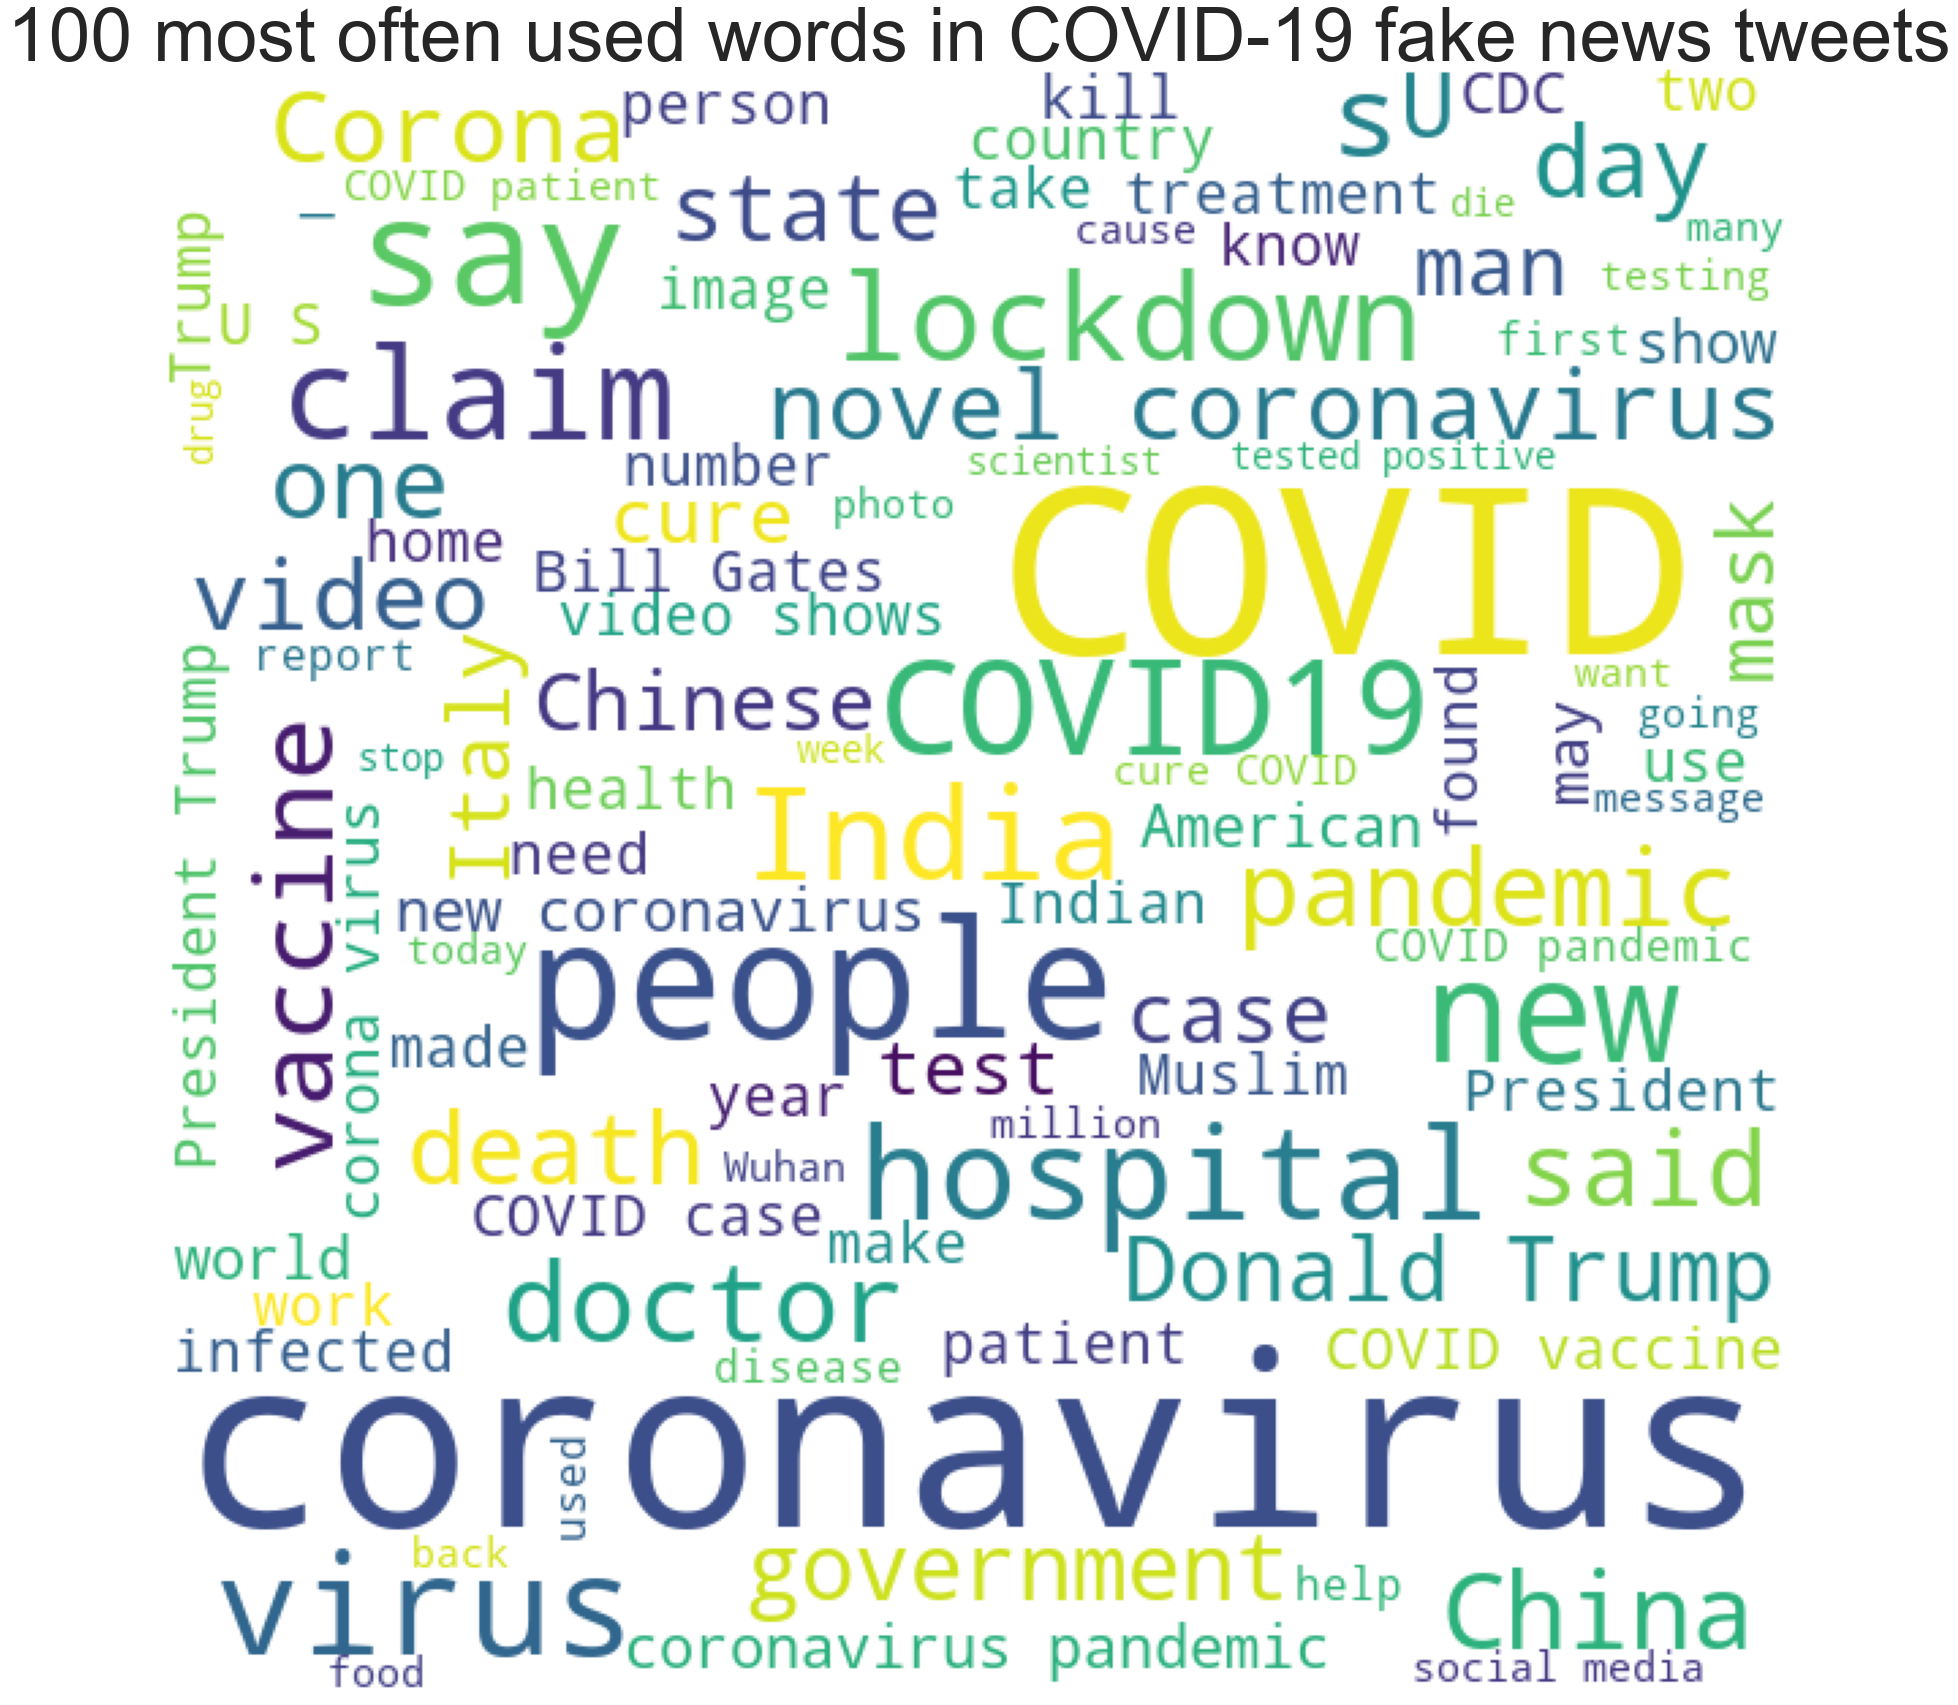

In [415]:
one_text_fake = ("")

for item in list(df.loc[df['label']=='fake', "processed_tweet"]):
    one_text_fake += (item)
    one_text_fake += ("\n")

words_tokens = twokenize(one_text_fake)

filtered_text = [w for w in words_tokens if not w in stop_words]
wl_space_split = " ".join(filtered_text)
word_cloud_1 = WordCloud(max_words=100, width=600, height=600, background_color='white').generate(wl_space_split)


plt.figure(figsize=(30,30))
plt.imshow(word_cloud_1)
plt.axis("off")
plt.title("100 most often used words in COVID-19 fake news tweets", fontdict={'fontsize':75})
plt.show()

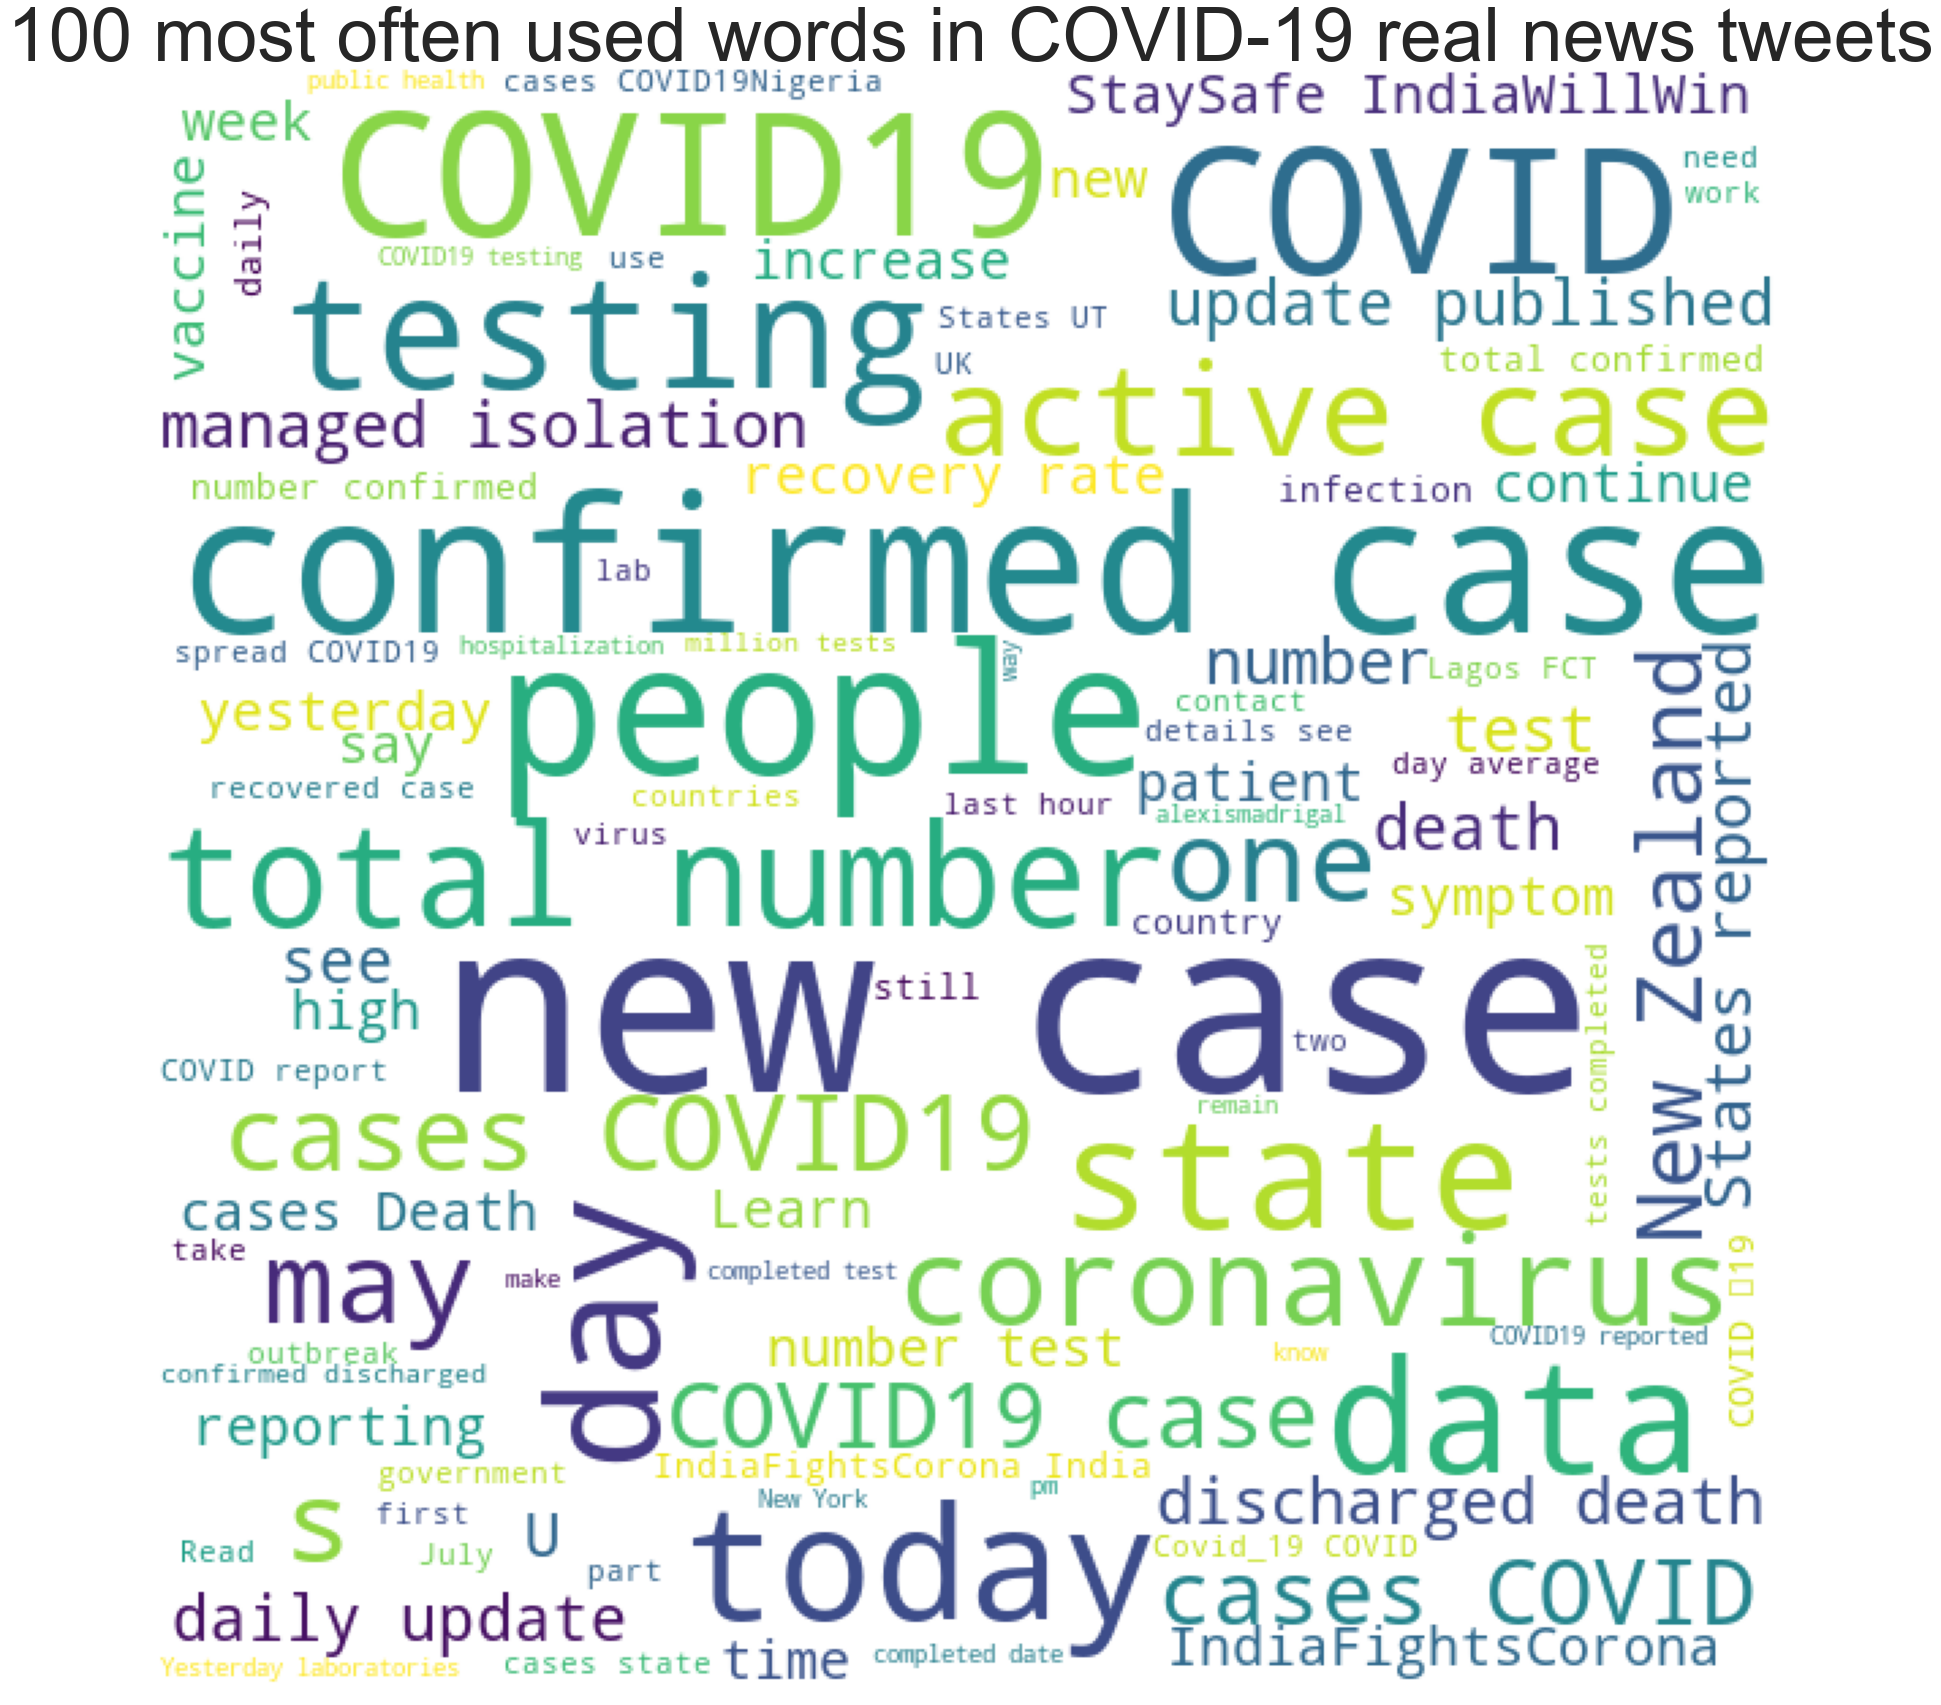

In [416]:
one_text_real = ("")

for item in list(df.loc[df['label']=='real', "processed_tweet"]):
    one_text_real += (item)
    one_text_real += ("\n")

words_tokens = twokenize(one_text_real)

filtered_text = [w for w in words_tokens if not w in stop_words]
wl_space_split = " ".join(filtered_text)
word_cloud_1 = WordCloud(max_words=100, width=600, height=600, background_color='white').generate(wl_space_split)


plt.figure(figsize=(30,30))
plt.imshow(word_cloud_1)
plt.axis("off")
plt.title("100 most often used words in COVID-19 real news tweets", fontdict={'fontsize':75})
plt.show()

This doesn't show alot, however, we can see some interesting differences:
- Donald Trump occurs as a frequently used word in fake news

<strong>investigating the mentions (looking for any network connections)</strong>

In [292]:
def find_mentions(tweet):
    mentions = re.findall(r'@\w+', tweet)
    return mentions

In [293]:
df['mentions'] = df.tweet.apply(find_mentions)

In [294]:
df.head()

tweet label  char_count  \
0  The CDC currently reports 99031 deaths. In gen...  real         190   
1  States reported 1121 deaths a small rise from ...  real         129   
2  Politically Correct Woman (Almost) Uses Pandem...  fake         131   
3  #IndiaFightsCorona: We have 1524 #COVID testin...  real         204   
4  Populous states can generate large case counts...  real         231   

   word_count                                    processed_tweet  \
0          29  The CDC currently reports 99031 deaths. In gen...   
1          18  States reported 1121 deaths a small rise from ...   
2          16  Politically Correct Woman (Almost) Uses Pandem...   
3          27  #IndiaFightsCorona: We have 1524 #COVID testin...   
4          42  Populous states can generate large case counts...   

                      mentions  
0                           []  
1                           []  
2                           []  
3  [@ProfBhargava, @ICMRDELHI]  
4                           []

In [295]:
#find all mentions for real and fake tweets separately

mentions_real = df.loc[df['label']=="real", "mentions"].to_list()
mentions_fake = df.loc[df['label']=="fake", "mentions"].to_list()

In [296]:
mentions_all_fake = []
mentions_all_real = []

for lst in mentions_fake:
    for i in lst:
        mentions_all_fake.append(i)
        
for lst in mentions_real:
    for i in lst:
        mentions_all_real.append(i)

len(mentions_all_fake + mentions_all_real)

3602

In [300]:
df_mentions_real = pd.DataFrame(mentions_all_real, columns=['real_mention'])

df_mentions_real["count"] = 1

df_mentions_real = df_mentions_real.groupby("real_mention").count().sort_values(by='count', ascending=False)

df_mentions_real.head(10) #let's display 10 most often used mentions for real tweets

count
real_mention           
@MoHFW_INDIA        253
@ICMRDELHI          185
@DrTedros           169
@drharshvardhan     159
@PIB_India          124
@alexismadrigal      88
@CDCMMWR             64
@PMOIndia            57
@AshwiniKChoubey     49
@DDNewslive          47

In [299]:
df_mentions_fake = pd.DataFrame(mentions_all_fake, columns=['fake_mention'])

df_mentions_fake["count"] = 1

df_mentions_fake = df_mentions_fake.groupby("fake_mention").count().sort_values(by='count', ascending=False)

df_mentions_fake.head(10) #let's display 10 most often used mentions for fake tweets

count
fake_mention           
@realDonaldTrump     27
@narendramodi        19
@factchecknet        18
@PMOIndia            14
@WHO                 10
@MoHFW_INDIA          9
@ArvindKejriwal       9
@csogok               6
@KHNews               6
@PolitiFactWisc       5

In [72]:
print(f"""{np.sum(df_mentions_fake['count'])} mentions in all of the fake news in our database
{np.sum(df_mentions_real['count'])} mentions in all of the real news in our database""")

913 mentions in all of the fake news in our database
2689 mentions in all of the real news in our database


In [73]:
#now, let's show all of the mentions in one table
mentions = df['mentions'].to_list()

In [74]:
mentions_all = []

for lst in mentions:
    for i in lst:
        mentions_all.append(i)

In [75]:
len(mentions_all)

3602

In [97]:
df_mentions = pd.DataFrame(mentions_all, columns=["mention"])

df_mentions["count"] = 1

df_mentions.groupby("mention").count().sort_values(by='count', ascending=False).head(10)

count
mention                
@MoHFW_INDIA        262
@ICMRDELHI          186
@DrTedros           169
@drharshvardhan     164
@PIB_India          124
@alexismadrigal      88
@PMOIndia            71
@CDCMMWR             64
@AshwiniKChoubey     49
@WHO                 48

In [78]:
del df['mentions']

<br>Now, let's do the same for hashtags

In [301]:
def find_hashtags(tweet):
    hashtags = re.findall(r'#\w+', tweet)
    return hashtags

In [302]:
df['hashtags'] = df.tweet.apply(find_hashtags)

In [303]:
hashtags_real = df.loc[df['label']=="real", "hashtags"].to_list()
hashtags_fake = df.loc[df['label']=="fake", "hashtags"].to_list()

In [304]:
hashtags_all_fake = []
hashtags_all_real = []

for lst in hashtags_fake:
    for i in lst:
        hashtags_all_fake.append(i)
        
for lst in hashtags_real:
    for i in lst:
        hashtags_all_real.append(i)

len(hashtags_all_fake + hashtags_all_real)

8507

In [305]:
df_hashtags_real = pd.DataFrame(hashtags_all_real, columns=['real_hashtag'])

df_hashtags_real["count"] = 1

df_hashtags_real = df_hashtags_real.groupby("real_hashtag").count().sort_values(by='count', ascending=False)
df_hashtags_real.head(10) #let's display 10 most commonly used hashtags in real news

count
real_hashtag              
#COVID19              2092
#IndiaFightsCorona     546
#coronavirus           293
#CoronaVirusUpdates    269
#StaySafe              224
#IndiaWillWin          195
#COVID                 154
#COVID19Nigeria        148
#COVIDー19              120
#TakeResponsibility    100

In [308]:
df_hashtags_fake = pd.DataFrame(hashtags_all_fake, columns=['fake_hashtag'])

df_hashtags_fake["count"] = 1

df_hashtags_fake = df_hashtags_fake.groupby("fake_hashtag").count().sort_values(by='count', ascending=False)
df_hashtags_fake.head(10) #let's display 10 most commonly used hashtags in fake news

count
fake_hashtag            
#coronavirus         383
#COVID19             185
#covid19             104
#donaldtrump         100
#CoronavirusFacts     40
#pandemic             32
#CoronaCheck          23
#COVIDー19             22
#china                22
#coronavirusfacts     22

In [307]:
print(f"""{np.sum(df_hashtags_fake['count'])} hashtags in all of the fake news in our database
{np.sum(df_hashtags_real['count'])} hashtags in all of the real news in our database""")

2490 hashtags in all of the fake news in our database
6017 hashtags in all of the real news in our database


In [309]:
#calculating it for the whole dataset

hashtags = df['hashtags'].to_list()

In [310]:
hashtags_all = []

for lst in hashtags:
    for i in lst:
        hashtags_all.append(i)

In [311]:
df_hashtags = pd.DataFrame(hashtags_all, columns=["hashtag"])

df_hashtags["count"] = 1

df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False)

count
hashtag                      
#COVID19                 2277
#coronavirus              676
#IndiaFightsCorona        551
#CoronaVirusUpdates       277
#StaySafe                 228
...                       ...
#StopTheSpreadOfCorona      1
#StopTheSpread              1
#StockMarketCrash2020       1
#Stimuluschecks             1
#陳秋實                        1

[1449 rows x 1 columns]

In [93]:
df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False).loc[df_hashtags.groupby("hashtag").count().sort_values(by='count', ascending=False)["count"] > 50,:]
#let's display hashtags used at least 50 times in our dataset:


count
hashtag                   
#COVID19              2277
#coronavirus           676
#IndiaFightsCorona     551
#CoronaVirusUpdates    277
#StaySafe              228
#IndiaWillWin          195
#COVID                 166
#COVID19Nigeria        148
#COVIDー19              142
#covid19               115
#COVID__19             101
#donaldtrump           100
#TakeResponsibility    100
#CoronavirusIndia       93
#Covid_19               78
#COVID_19               73
#COVIDUpdates           67
#CoronaUpdates          63
#COVIDView              52

In [312]:
del df['hashtags']

It can be concluded that according to available data, both <strong>hashtags</strong> and <strong>mentions</strong> are rather used in <strong>REAL NEWS</strong><br>

However, we cannot be sure that this observation is significant since our dataset is not very representative. We believe that this may be a great place to start a separate research on importance of hashtags and mentions in case of real/fake classification :)

For the purposes of this project, we will remove mentions and hashtags completely from the tweets while processing them, since we are not sure about their importance and there is a risk that they will introduce unwanted noise to our data.

<br><br><strong>Checking the distribution of labels in all of the datasets</strong>

tweet  processed_tweet
label                        
fake    5100             5100
real    5600             5600

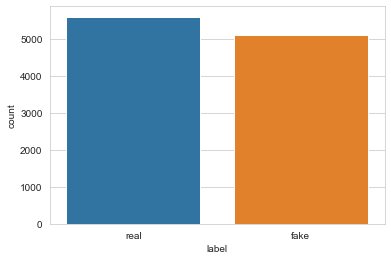

In [99]:
#check the distribution of the labels:

sns.set_style("whitegrid")

sns.countplot(df['label'])

df.groupby('label').count().iloc[:,0:2]

Are the groups statistically equal?

In [354]:
from scipy.stats import chisquare

array_of_labels = df.label.apply(lambda x: 1 if x == 'real' else 0).to_numpy()

chisquare(f_obs = array_of_labels)

Power_divergenceResult(statistic=5100.0, pvalue=1.0)

<strong>p-value</strong> is higher then 0.05, which means that the result of chi-square test is significant so that we can assume that researched groups of tweets are statistically equal

<strong>Some more of Data Processing</strong><br>

<p>let's deal with so-called <i>split-joined words</i> like "GoodMorning" or "HelloWorld"

In [103]:
def process_split_joined(text):
    processed_text = " ".join(re.findall("[A-Z][^A-Z]*",text))
    return processed_text

#don't know yet how to deal with it and do not crack names like COVID or CDC

Now, it's turn for mentions (as they may not be useful in our case)

In [417]:
def remove_mentions(text):
    x = re.sub(r'@\w+',' ',text)
    return x

In [418]:
df['processed_tweet'] = df['processed_tweet'].apply(remove_mentions)

Dealing with grammar and spelling mistakes:

In [424]:
tool = language_tool_python.LanguageTool('en-US')

def correct_grammar(text):
    text = tool.correct(text)
    return text

In [425]:
example_text = "How covid-19 killz peiple?"

print(correct_grammar(example_text))

How COVID-19 kill people?


In [426]:
for i in tool.check(example_text): #how does it work on COVID-19 related text?
    print(i)

Offset 4, length 8, Rule ID: COVID_19
Message: Did you mean “COVID-19” or the alternative spelling “Covid-19” (= coronavirus)?
Suggestion: COVID-19; Covid-19
How covid-19 killz peiple?
    ^^^^^^^^
Offset 13, length 5, Rule ID: MORFOLOGIK_RULE_EN_US
Message: Possible spelling mistake found.
Suggestion: kill; kills
How covid-19 killz peiple?
             ^^^^^
Offset 19, length 6, Rule ID: MORFOLOGIK_RULE_EN_US
Message: Possible spelling mistake found.
Suggestion: people; pale; maple
How covid-19 killz peiple?
                   ^^^^^^


In [427]:
df['processed_tweet'] = df['processed_tweet'].apply(correct_grammar)

Now, let's remove punctuation

In [428]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [429]:
def remove_punctuations(text):
    text = "".join([punc for punc in text if not punc in punctuation])
    return text

In [430]:
df['processed_tweet'] = df['processed_tweet'].apply(remove_punctuations)

Lowering the text of all tweets:

In [431]:
df['processed_tweet'] = df['processed_tweet'].apply(lambda x: x.lower())

Removing the stopwords (as they may not be useful in case of our predictions)

In [432]:
stop_words = stopwords.words("English")
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [433]:
def remove_stopwords(text):
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    return text

In [434]:
df['processed_tweet']=df['processed_tweet'].apply(remove_stopwords)

<strong>Now, let's encode the labels</strong>

1 is real, 0 is fake

In [435]:
df['label_enc'] = df['label'].apply(lambda x: 1 if x=='real' else 0)

In [436]:
df.head()

tweet label  char_count  \
0  The CDC currently reports 99031 deaths. In gen...  real         190   
1  States reported 1121 deaths a small rise from ...  real         129   
2  Politically Correct Woman (Almost) Uses Pandem...  fake         131   
3  #IndiaFightsCorona: We have 1524 #COVID testin...  real         204   
4  Populous states can generate large case counts...  real         231   

   word_count  proper                                    processed_tweet  \
0          29    True  cdc currently reports 99031 deaths general dis...   
1          18    True  states reported 1121 deaths small rise last tu...   
2          16    True  politically correct woman almost uses pandemic...   
3          27    True  indiafightscorona 1524 covid19 testing laborat...   
4          42    True  populous states generate large case counts loo...   

   label_enc  
0          1  
1          1  
2          0  
3          1  
4          1

Analyze the lenghts of processed tweets

In [437]:
df['char_count_p'] = df['processed_tweet'].apply(char_count)
df['word_count_p'] = df['processed_tweet'].apply(word_count)

In [441]:
df.sort_values(by='char_count_p', ascending=False).tail(10)

tweet label  char_count  \
6129                         WHO changed its directives  fake          26   
1140                                 Pier Luigi Bersani  fake          18   
3462                         NO MORE CORONA VIRUS DEATH  fake          26   
1883                              COVID-19 is Airborne.  fake          21   
4885  @dandiemann @joshtpm At least we're not still ...  real          54   
2742         There is now a COVID-19 cure from the USA.  fake          42   
9035  Lockdown is only for Hindus.\n@KapilMishra_IND...  fake         113   
268                                There is no pandemic  fake          20   
141   Where Are They Now: Covid-19 https://t.co/j6AA...  fake          52   
3600                 Now cases. https://t.co/APHMFyirSj  real          34   

      word_count  proper     processed_tweet  label_enc  char_count_p  \
6129           4    True  changed directives          0            18   
1140           3    True  pier luigi bernini          0            18   
3462           5    True   coronavirus death          0            17   
1883           3    True    covid19 airborne          0            16   
4885           9    True    least still 2000          1            16   
2742           9    True    covid19 cure usa          0            16   
9035          10    True     lockdown hindus          0            15   
268            4    True            pandemic          0             8   
141            6    True             covid19          0             7   
3600           3    True               cases          1             5   

      word_count_p  
6129             2  
1140             3  
3462             2  
1883             2  
4885             3  
2742             3  
9035             2  
268              1  
141              1  
3600             1

There are no empty tweets among processed tweets, however, the shortest may not be significant in results 

In [381]:
df.sort_values(by='word_count_p', ascending=False).iloc[:20,:]

tweet label  char_count  \
10029  I’ve never had a chance to work on something t...  real       10170   
270    Amoxi" Capsule made in US is the only medicine...  fake        8846   
1109   Actors" applauded Macron when he visited the s...  fake        5040   
9066   NYC man drops dead in middle of street — suspe...  fake        2160   
6306   Man visited Albany N.Y. days before dying from...  fake        2086   
8153   I'm so happy that we’re able to do something v...  real        2135   
9095   Gale of the wind" and "Neem Tree" leaves are g...  fake        1301   
773    @giles7452 @William05548637 @CheeseNBranston @...  fake         922   
6467   In our laboratory, we found trace amount of th...  fake         723   
4349   @Narvuntien @jimdtweet @MedBennett @TheDisproo...  fake         880   
9701   @TomDoubting @emsops @Gram247 @Lastplace_champ...  fake         895   
4147   COVID-19, Take one minute and read. Be underst...  fake         695   
6872   IN ISRAEL NO DEATH FROM C-19 ! He told them a ...  fake         633   
8924   World Steam Week, According to doctors, if COV...  fake         673   
6624   A Good News* Finally an INDIAN student from PO...  fake         520   
6662   A Good News* Finally an INDIAN student from PO...  fake         520   
6314   Mask wearers beware. A caller to a radio talk ...  fake         545   
3265   Finally a INDIAN student from PONDICHERRY univ...  fake         504   
3745   Mask wearers beware. A caller to a radio talk ...  fake         545   
7452   As at 10:20 pm 16th April number of states wit...  real         272   

       word_count  proper                                    processed_tweet  \
10029        1433   False  i’ve never chance work something that’s highle...   
270          1409   False  among” capsule made us medicine completely cur...   
1109          823   False  actors” applauded macron visited suburban city...   
9066          330   False  nycs man drops dead middle street — suspected ...   
6306          326   False  man visited albany ny days dying coronavirus” ...   
8153          297   False  im happy we’re able something concrete help pe...   
9095          204   False  gale wind” “need tree” leaves good medicine pr...   
773            93   False  giles7452 william05548637 cheesenbranston bria...   
6467          130   False  laboratory found trace amount virus skin fruit...   
4349           86   False  narvuntien jimdtweet medbennett thedisproof pt...   
9701           81   False  tomdoubting seasons gram247 laplacechamp rjoco...   
4147          119   False  covid19 take one minute read understanding jap...   
6872          116   False  israel death c19 told super news … arrived sen...   
8924          122   False  world steam week according doctors covid19 hit...   
6624           91   False  good news finally indian student pondicherry u...   
6662           91   False  good news finally indian student pondicherry u...   
6314           98   False  mask wearers beware caller radio talk show rec...   
3265           87   False  finally indian student pondicherry university ...   
3745           98   False  mask wearers beware caller radio talk show rec...   
7452           57    True  1020 pm 16th april number states confirmed cas...   

       label_enc  char_count_p  word_count_p  
10029          1          6541           899  
270            0          6530           887  
1109           0          3628           503  
9066           0          1594           213  
6306           0          1565           211  
8153           1          1361           191  
9095           0           933           122  
773            0           787            77  
6467           0           466            71  
4349           0           734            71  
9701           0           764            70  
4147           0           475            65  
6872           0           402            61  
8924           0           422            61  
6624           0          

In [382]:
np.mean(df.char_count_p)

123.66364485981309

Let's check what is the maximum number of words for all proper tweets

In [443]:
df.loc[df.proper == True, :].word_count_p.max()

50

We can consider setting the input length for our algorithm as the number of maximum number of words in the tweets. In order to do it, we'll need to truncate all of the longer records

In [444]:
df.to_csv('FakeNews_preprocessed.csv')

Let's check whether there are any empty records after processing:

In [445]:
print("Empty post-processing tweets: \n", df.loc[df["processed_tweet"] == ""])

Empty post-processing tweets: 
 Empty DataFrame
Columns: [tweet, label, char_count, word_count, proper, processed_tweet, label_enc, char_count_p, word_count_p]
Index: []


<strong>Now, it's time for tokenization and padding!</strong>

In [450]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df.processed_tweet)

#we will need to save the tokenizer later on
#https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

In [802]:
import pickle

#saving the tokenizer
with open('fake_news_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 

#code for loading the tokenizer
#with open('fake_news_tokenizer.pickle', 'rb') as handle:
#    tokenizer_test = pickle.load(handle)

In [451]:
#check the number of unique tokens

tokens_num = len(tokenizer.word_index) + 1

print(f"found {tokens_num} unique tokens") # print the number of detected tokens

found 21629 unique tokens


In [452]:
sequences_tweets = tokenizer.texts_to_sequences(df['processed_tweet'].values)

In [453]:
maxlen = 50

In [456]:
x_train, x_test, y_train, y_test = train_test_split(sequences_tweets, df['label_enc'].values, test_size=0.3)

x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

In [457]:
x_train.shape

(7490, 50)

<strong>Also, we'll need a function for processing new single tweets</strong>

In [751]:
def process_single_tweet(text):
    to_process = text
    
    to_process = del_url(to_process) #remove any URLs starting with HTTPS
    to_process = remove_mentions(to_process) #remove any @mentions
    
    to_process = correct_grammar(to_process) #correct grammar mistakes
    to_process = remove_punctuations(to_process) #remove punctuation
    
    to_process = to_process.lower() #lower text
    to_process = remove_stopwords(to_process) #remove all stopwords
    
    to_process = tokenizer.texts_to_sequences([to_process])[0] #tokenize the text with the tokenizer trained on our data
    to_process = pad_sequences([to_process], maxlen=50, padding='post')
    
    return to_process

In [752]:
sample_text = "Donald Trump cures covid-19 infetctions! @realDonaldTrump"

print(process_single_tweet(sample_text))

[[ 82  29 626   1 231   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


Great! The function <i>process_single_tweet</i> works fine :)

<strong>Once we have everything, let's move to creating the model!!!</strong>

In [504]:
#import some elements for creating the mode
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Bidirectional, SimpleRNN, GRU, LSTM, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras import metrics

from sklearn.metrics import classification_report, confusion_matrix

This is how we are going to evaluate our models:
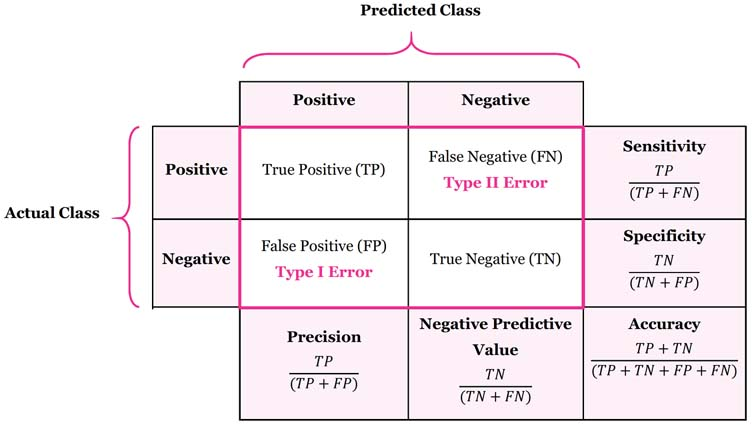
We will evaluate our model with <strong>sensitivity and sphericity</strong>

Sensitivity (aka Recall) means “out of all actual Positives, how many did we predict as Positive”, which can be explained as:<br>
Sensitivity (Recall) = TP / (FN + TP)<br>
Specificity (aka Selectivity or True Negative Rate, TNR) means “out of all actual Negatives, how many did we predict as Negative”, and can be written as:<br>
Specificity = TN / (TN + FP)


In [607]:
metrics_1=['acc', metrics.TruePositives(), metrics.TrueNegatives(), metrics.FalsePositives(), metrics.FalseNegatives()]

def evaluate_metrics(model, xtest, ytest): #define a function for printing all of the metrics 
    metric_list = model.evaluate(xtest, ytest)
    for name, metric in zip(metrics_1[-4:], metric_list[-4:] ):
        str_name = str(name).split('.')[-1].split(" ")[0]
        print(f"{str_name} -- {metric}")
    
    sensitivity = metric_list[2] / (metric_list[-1] + metric_list[2])
    specificity = metric_list[3] / (metric_list[3] + metric_list[-2])
    precision = metric_list[2] / (metric_list[2] + metric_list[-2])
    
    print(f"\nSensitivity (recall) -- {sensitivity}\nSpecificity -- {specificity}\nPrecision -- {precision}")
    
    print(f"\nAccuracy -- {metric_list[1]}\nLoss -- {metric_list[0]}")
    
    
def display_confusion_matrix(model, xtest, ytest): #define a function for displaying confusion matrix for training performance
    df_cm = pd.DataFrame(data=confusion_matrix(y_true = y_test, y_pred=predictions_1),
                 columns = ['Predicted Negative', 'Predicted Positive'],
                 index = ['Actual Negative', 'Actual Positive'])
    return df_cm
     

In order to prevent overfitting, we are going to implement Dropout layers, early stopping callback and L2 weights regularization

In [581]:
from keras import regularizers
from keras.callbacks import EarlyStopping

In [665]:
early_stop = EarlyStopping(patience=3, verbose=1, min_delta=0.0001,restore_best_weights=True)

First, let's create a very simple model built of embedding and Dense layer

In [508]:
model1 = Sequential()

model1.add(Embedding(input_dim=tokens_num, output_dim=16, input_length=maxlen))
model1.add(Flatten())
model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = metrics_1)

model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            346064    
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 801       
Total params: 346,865
Trainable params: 346,865
Non-trainable params: 0
_________________________________________________________________


In [509]:
history1 = model1.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.3,
                    callbacks=[early_stop])

Epoch 1/10
164/164 [==============================] - 2s 4ms/step - loss: 0.6318 - acc: 0.6869 - true_positives_1: 1082.2970 - true_negatives_1: 815.3152 - false_positives_1: 436.0970 - false_negatives_1: 322.0364 - val_loss: 0.4737 - val_acc: 0.7726 - val_true_positives_1: 957.0000 - val_true_negatives_1: 779.0000 - val_false_positives_1: 274.0000 - val_false_negatives_1: 237.0000
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 0.4215 - acc: 0.8064 - true_positives_1: 1172.7333 - true_negatives_1: 987.9212 - false_positives_1: 254.8909 - false_negatives_1: 240.2000 - val_loss: 0.3469 - val_acc: 0.8567 - val_true_positives_1: 1037.0000 - val_true_negatives_1: 888.0000 - val_false_positives_1: 165.0000 - val_false_negatives_1: 157.0000
Epoch 3/10
164/164 [==============================] - 0s 1ms/step - loss: 0.2797 - acc: 0.8940 - true_positives_1: 1241.3697 - true_negatives_1: 1135.0606 - false_positives_1: 114.5333 - false_negatives_1: 164.7818 - val_loss: 0.

In [698]:
evaluate_metrics(model1, x_test, y_test)

101/101 [==============================] - 0s 973us/step - loss: 0.1831 - acc: 0.9280 - true_positives_1: 1518.0000 - true_negatives_1: 1461.0000 - false_positives_1: 112.0000 - false_negatives_1: 119.0000
TruePositives -- 1518.0
TrueNegatives -- 1461.0
FalsePositives -- 112.0
FalseNegatives -- 119.0

Sensitivity (recall) -- 0.9273060476481368
Specificity -- 0.9287984742530198
Precision -- 0.9312883435582822

Accuracy -- 0.9280374050140381
Loss -- 0.1831013560295105


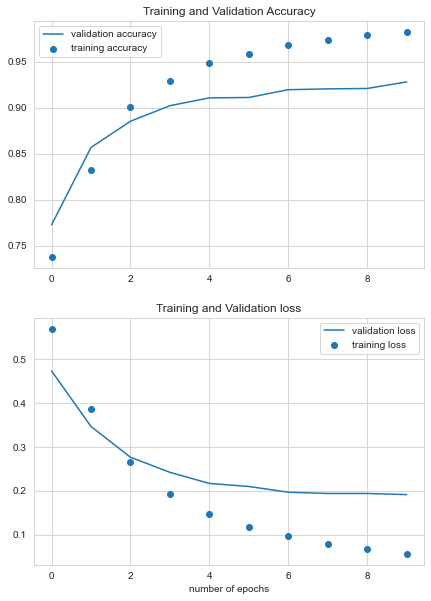

In [699]:
display_training_curves(history1)

Now, let's check how a BIDIRECTIONAL GRU layer will perform in our case -- we'll set its output dimension to 256

In [714]:
model2 = Sequential()

model2.add(Embedding(input_dim=tokens_num, output_dim=32, input_length=maxlen))

model2.add(Bidirectional(GRU(256, return_sequences=True)))
model2.add(GlobalAveragePooling1D())

model2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =metrics_1)

model2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 50, 32)            692128    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 50, 512)           445440    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 65        
Total params: 1,170,465
Trainable params: 1,170,465
Non-trainable params: 0
___________________________________________

In [710]:
history2 = model2.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.1,
                   callbacks=[early_stop])

Epoch 1/10
211/211 [==============================] - 18s 70ms/step - loss: 0.5962 - acc: 0.7004 - true_positives: 2813.2830 - true_negatives: 2716.8396 - false_positives: 459.9104 - false_negatives: 627.7123 - val_loss: 0.3580 - val_acc: 0.8558 - val_true_positives: 279.0000 - val_true_negatives: 362.0000 - val_false_positives: 6.0000 - val_false_negatives: 102.0000
Epoch 2/10
211/211 [==============================] - 15s 70ms/step - loss: 0.2298 - acc: 0.9254 - true_positives: 1684.3066 - true_negatives: 1481.7123 - false_positives: 122.2264 - false_negatives: 119.5000 - val_loss: 0.1768 - val_acc: 0.9386 - val_true_positives: 356.0000 - val_true_negatives: 347.0000 - val_false_positives: 21.0000 - val_false_negatives: 25.0000
Epoch 3/10
211/211 [==============================] - 15s 69ms/step - loss: 0.1454 - acc: 0.9562 - true_positives: 1732.7877 - true_negatives: 1520.2028 - false_positives: 72.6840 - false_negatives: 82.0708 - val_loss: 0.1973 - val_acc: 0.9199 - val_true_posit

In [711]:
evaluate_metrics(model2, x_test, y_test)

101/101 [==============================] - 2s 18ms/step - loss: 0.1884 - acc: 0.9330 - true_positives: 1510.0000 - true_negatives: 1485.0000 - false_positives: 88.0000 - false_negatives: 127.0000
TruePositives -- 1510.0
TrueNegatives -- 1485.0
FalsePositives -- 88.0
FalseNegatives -- 127.0

Sensitivity (recall) -- 0.9224190592547342
Specificity -- 0.9440559440559441
Precision -- 0.9449311639549437

Accuracy -- 0.9330217838287354
Loss -- 0.18844740092754364


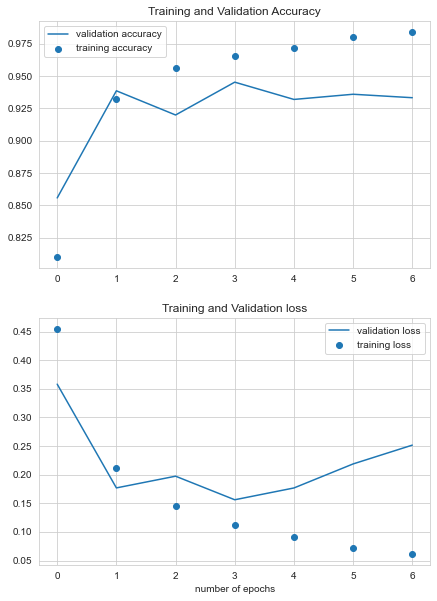

In [712]:
display_training_curves(history2)

Model with the GRU layer seems to perform quite well -- let's try to do the same for the LSTM layer:

In [716]:
model3 = Sequential()

model3.add(Embedding(input_dim=tokens_num, output_dim=32, input_length=maxlen))

model3.add(Bidirectional(LSTM(256, return_sequences=True)))
model3.add(GlobalAveragePooling1D())

model3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model3.add(Dropout(0.5))

model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =metrics_1)

model3.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 50, 32)            692128    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 50, 512)           591872    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 512)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 65        
Total params: 1,316,897
Trainable params: 1,316,897
Non-trainable params: 0
___________________________________________

In [718]:
history3 = model3.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/10
211/211 [==============================] - 19s 88ms/step - loss: 0.3199 - acc: 0.8938 - true_positives: 3210.0000 - true_negatives: 2815.0000 - false_positives: 344.0000 - false_negatives: 372.0000 - val_loss: 0.1979 - val_acc: 0.9292 - val_true_positives: 354.0000 - val_true_negatives: 342.0000 - val_false_positives: 26.0000 - val_false_negatives: 27.0000
Epoch 2/10
211/211 [==============================] - 18s 87ms/step - loss: 0.1805 - acc: 0.9478 - true_positives: 3415.0000 - true_negatives: 2974.0000 - false_positives: 185.0000 - false_negatives: 167.0000 - val_loss: 0.1891 - val_acc: 0.9439 - val_true_positives: 361.0000 - val_true_negatives: 346.0000 - val_false_positives: 22.0000 - val_false_negatives: 20.0000
Epoch 3/10
211/211 [==============================] - 19s 88ms/step - loss: 0.1307 - acc: 0.9591 - true_positives: 3463.0000 - true_negatives: 3002.0000 - false_positives: 157.0000 - false_negatives: 119.0000 - val_loss: 0.2926 - val_acc: 0.8959 - val_true_pos

In [719]:
evaluate_metrics(model3, x_test, y_test)

101/101 [==============================] - 2s 24ms/step - loss: 0.2444 - acc: 0.9212 - true_positives: 1494.0000 - true_negatives: 1463.0000 - false_positives: 110.0000 - false_negatives: 143.0000
TruePositives -- 1494.0
TrueNegatives -- 1463.0
FalsePositives -- 110.0
FalseNegatives -- 143.0

Sensitivity (recall) -- 0.9126450824679292
Specificity -- 0.9300699300699301
Precision -- 0.9314214463840399

Accuracy -- 0.9211838245391846
Loss -- 0.24437282979488373


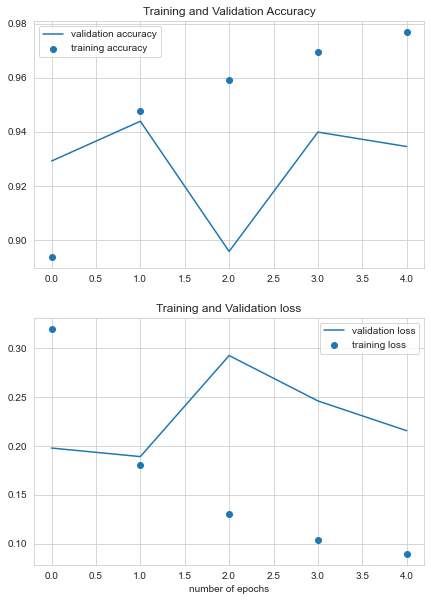

In [720]:
display_training_curves(history3)

Let's modify the Bidirectional LSTM model a little bit

In [725]:
model4 = Sequential()

model4.add(Embedding(input_dim=tokens_num, output_dim=32, input_length=maxlen, ))

model4.add(Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))))
model4.add(GlobalMaxPooling1D())

model4.add(Dropout(0.3))

model4.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model4.add(Dropout(0.3))

model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =metrics_1)

model4.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 50, 32)            692128    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 512)           591872    
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 512)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_59 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 1)               

In [726]:
history4 = model4.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.1,
                   callbacks = [early_stop])

Epoch 1/10
211/211 [==============================] - 25s 96ms/step - loss: 0.6704 - acc: 0.6909 - true_positives: 1837.3868 - true_negatives: 1375.2642 - false_positives: 571.7028 - false_negatives: 372.3915 - val_loss: 0.3130 - val_acc: 0.8852 - val_true_positives: 312.0000 - val_true_negatives: 351.0000 - val_false_positives: 17.0000 - val_false_negatives: 69.0000
Epoch 2/10
211/211 [==============================] - 20s 95ms/step - loss: 0.2879 - acc: 0.9067 - true_positives: 1620.3349 - true_negatives: 1472.8019 - false_positives: 118.5094 - false_negatives: 196.0991 - val_loss: 0.2379 - val_acc: 0.9212 - val_true_positives: 361.0000 - val_true_negatives: 329.0000 - val_false_positives: 39.0000 - val_false_negatives: 20.0000
Epoch 3/10
211/211 [==============================] - 19s 91ms/step - loss: 0.1842 - acc: 0.9429 - true_positives: 1721.1179 - true_negatives: 1491.6462 - false_positives: 95.1509 - false_negatives: 99.8302 - val_loss: 0.2323 - val_acc: 0.9319 - val_true_posit

In [727]:
evaluate_metrics(model4, x_test, y_test)

101/101 [==============================] - 2s 22ms/step - loss: 0.2043 - acc: 0.9327 - true_positives: 1524.0000 - true_negatives: 1470.0000 - false_positives: 103.0000 - false_negatives: 113.0000
TruePositives -- 1524.0
TrueNegatives -- 1470.0
FalsePositives -- 103.0
FalseNegatives -- 113.0

Sensitivity (recall) -- 0.9309712889431888
Specificity -- 0.9345200254291164
Precision -- 0.9366933005531654

Accuracy -- 0.9327102899551392
Loss -- 0.20425912737846375


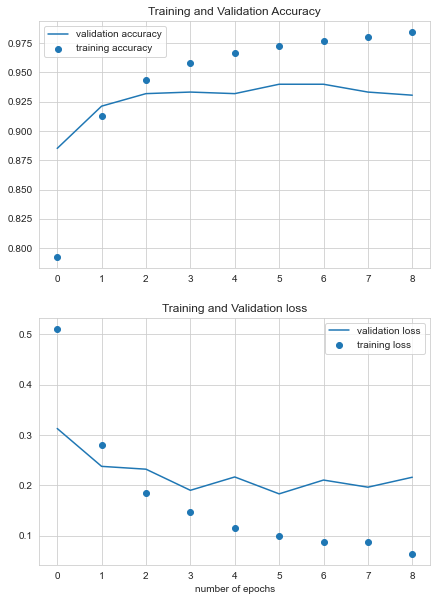

In [728]:
display_training_curves(history4)

WOW! Model 4 seems to perform great -- all of the metrics are on a decent level<br><br>
Let's try one more thing (model with two non-bidirectional LSTM layers):

In [760]:
model5 = Sequential()

model5.add(Embedding(input_dim=tokens_num, output_dim=32, input_length=maxlen, ))

model5.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model5.add(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model5.add(GlobalMaxPooling1D())

model5.add(Dropout(0.3))

model5.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model5.add(Dropout(0.3))

model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =metrics_1)

model5.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 50, 32)            692128    
_________________________________________________________________
lstm_32 (LSTM)               (None, 50, 128)           82432     
_________________________________________________________________
lstm_33 (LSTM)               (None, 50, 64)            49408     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 64)                0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)              

In [761]:
history5 = model5.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.1,
                   callbacks = [early_stop])

Epoch 1/10
211/211 [==============================] - 17s 42ms/step - loss: 0.6831 - acc: 0.6845 - true_positives: 2978.6981 - true_negatives: 2522.8868 - false_positives: 654.7877 - false_negatives: 461.3726 - val_loss: 0.3380 - val_acc: 0.8879 - val_true_positives: 326.0000 - val_true_negatives: 339.0000 - val_false_positives: 29.0000 - val_false_negatives: 55.0000
Epoch 2/10
211/211 [==============================] - 8s 39ms/step - loss: 0.2476 - acc: 0.9265 - true_positives: 1654.4104 - true_negatives: 1506.0849 - false_positives: 100.7689 - false_negatives: 146.4811 - val_loss: 0.2280 - val_acc: 0.9252 - val_true_positives: 363.0000 - val_true_negatives: 330.0000 - val_false_positives: 38.0000 - val_false_negatives: 18.0000
Epoch 3/10
211/211 [==============================] - 8s 39ms/step - loss: 0.1600 - acc: 0.9556 - true_positives: 1729.7028 - true_negatives: 1518.9434 - false_positives: 81.3726 - false_negatives: 77.7264 - val_loss: 0.2210 - val_acc: 0.9332 - val_true_positiv

In [762]:
evaluate_metrics(model5, x_test, y_test)

101/101 [==============================] - 1s 12ms/step - loss: 0.2444 - acc: 0.9212 - true_positives: 1490.0000 - true_negatives: 1467.0000 - false_positives: 106.0000 - false_negatives: 147.0000
TruePositives -- 1490.0
TrueNegatives -- 1467.0
FalsePositives -- 106.0
FalseNegatives -- 147.0

Sensitivity (recall) -- 0.9102015882712279
Specificity -- 0.9326128417037508
Precision -- 0.9335839598997494

Accuracy -- 0.9211838245391846
Loss -- 0.24442555010318756


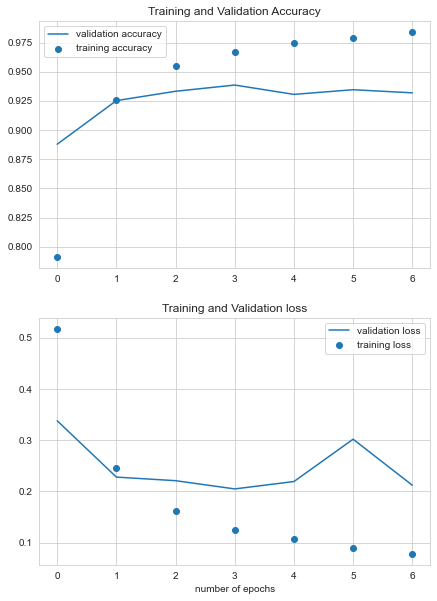

In [763]:
display_training_curves(history5)

It does not seem to perform better than Model numer 4 -- let's use model4 as our final model

First, let's save the model

In [797]:
from keras.models import save_model
model4.save("fake_news_model.h5", save_format='h5')

Then, define function for making a prediction

In [807]:
def predict_real_fake(text): #function for making predictions
    to_predict = process_single_tweet(text)
    
    prediction = float(model4.predict(to_predict)[0])
    
    if prediction > 0.5:
        return f"the model is {round(prediction*100, 2)}% sure that this tweet represents Real News about COVID-19"
    else:
        return f"the model is {round((1-prediction)*100,2)}% sure that this tweet represents Fake News about COVID-19"
    
    

In [808]:
predict_real_fake("Coronavirus does not exist! Bill Gates made it up for money! @WorldHealthOrganization")

'the model is 99.99% sure that this tweet represents Fake News about COVID-19'

In [809]:
predict_real_fake("Extremely huge number of new cases of coranavirus reported yesterday in Poland.")

'the model is 97.76% sure that this tweet represents Real News about COVID-19'